In [285]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from importlib import reload

import utils.models as models
import utils.plotting as plotting
import utils.dataloaders as dl
import utils.traintest as tt
import utils.adversarial as adv
import utils.eval as ev
import resnet
from tensorboardX import SummaryWriter


import argparse

import param as hps

device = torch.device('cuda:' + str(hps.gpu))
writer = SummaryWriter()

if hps.dataset=='MNIST':
    base_model = models.LeNetMadry().to(device)
    train_loader = dl.MNIST_train_loader
    noise_loader = dl.Noise_train_loader_MNIST
    test_loader = dl.MNIST_test_loader
elif hps.dataset=='CIFAR10':
    base_model = resnet.ResNet50().to(device).to(device)
    train_loader = dl.CIFAR10_train_loader
    noise_loader = dl.Noise_train_loader_CIFAR10
    test_loader = dl.CIFAR10_test_loader
    
noise_loader = dl.PrecomputeLoader(noise_loader)

if hps.use_gmm:
    loading_string = hps.dataset+'_n'+str(hps.n) 
    gmm = torch.load('SavedModels/gmm_'+loading_string+'.pth')
    gmm.alpha = nn.Parameter(gmm.alpha)
    model = models.RobustModel(base_model, gmm, hps.lam).to(device)
    model.loglam.requires_grad = False
else:
    model = base_model

saving_string = hps.dataset+'_lam'+str(hps.lam)+'_n'+str(hps.n)

lr = hps.lr

if hps.use_gmm:
    param_groups = [{'params':model.mm.parameters(),'lr':lr, 'weight_decay':0.},
                    {'params':model.base_model.parameters(),'lr':lr, 'weight_decay':hps.decay}]
else:
    param_groups = [{'params':model.parameters(),'lr':lr, 'weight_decay':hps.decay}]
    
optimizer = optim.Adam(param_groups)

for epoch in range(hps.epochs):
    if epoch+1 in [50,75,90]:
        for group in optimizer.param_groups:
            group['lr'] *= .1
    error = tt.train_ACET(model, device, train_loader, noise_loader, optimizer, epoch, steps=hps.steps, verbose=False)
    correct, ave_conf = tt.test(model, device, test_loader)
    writer.add_scalar('TestSet/TrainLoss', error, epoch)
    writer.add_scalar('TestSet/Correct', correct, epoch)
    writer.add_scalar('TestSet/Confidence', ave_conf, epoch)
    if (epoch)%5==0:
        df = ev.evaluate(model, device, writer=writer)
        writer.add_scalar('AUROC/FMNIST', df['AUROC'].iloc[1], epoch)
        writer.add_scalar('AUROC/EMNIST', df['AUROC'].iloc[2], epoch)
        writer.add_scalar('AUROC/GrayCIFAR10', df['AUROC'].iloc[3], epoch)
        writer.add_scalar('AUROC/Noise', df['AUROC'].iloc[4], epoch)
        writer.add_scalar('AUROC/AdvNoise', df['AUROC'].iloc[5], epoch)
        writer.add_scalar('AUROC/AdvSample', df['AUROC'].iloc[6], epoch)
        
        writer.add_scalar('MMC/FMNIST', df['MMC'].iloc[1], epoch)
        writer.add_scalar('MMC/EMNIST', df['MMC'].iloc[2], epoch)
        writer.add_scalar('MMC/GrayCIFAR10', df['MMC'].iloc[3], epoch)
        writer.add_scalar('MMC/Noise', df['MMC'].iloc[4], epoch)
        writer.add_scalar('MMC/AdvNoise', df['MMC'].iloc[5], epoch)
        writer.add_scalar('MMC/AdvSample', df['MMC'].iloc[6], epoch)

71.9 ms ± 4.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
from importlib import reload
import utils.dataloaders as dl

In [17]:
import torch
from torchvision import datasets, transforms
import torch.utils.data as data_utils
import numpy as np

In [22]:
import utils.preproc as pre
import matplotlib.pyplot as plt

In [78]:
data = enumerate(dl.imagenet_test_loader).__next__()[1][0]

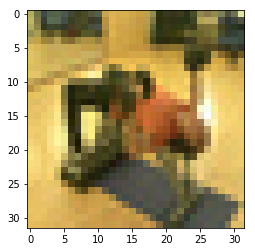

In [84]:
plt.imshow(data[5].permute(1,2,0))

In [17]:
import matplotlib.pyplot as plt

In [77]:
reload(dl)

<module 'utils.dataloaders' from '/home/alexm/project/notebooks/gmm-robust/utils/dataloaders.py'>